In [1]:
import sys
sys.path.append("../scripts")

import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from boa.datasets.labels import label_names_dict

save_dir = "../plots/notebook_plots/ordering/"

In [2]:
def load_permutation_data(path, name, kind, matrix_factorized=False):
    
    with open(path) as f:
        gpar_data = pd.read_json(f)
        
        dfs = []
        for i, row in gpar_data.iterrows():
            
            if kind in ["greedy"]:
                df = pd.DataFrame({
                    'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                    'index': row['index'],
                    'output': row['outputs'],
                    'size': row["size"],
                    'perm': str(row["perm"]),
                    "train_time": row["train_time"],
                    "predict_time": row["predict_time"],
                    "rmse": row["rmse"],
                    "mean_abs_err": row["mean_abs_err"],
                    "mean_squ_err": row["mean_squ_err"],
                    
                    "search_mode": "greedy"
                })
            elif kind in ["random"]:
                df = pd.DataFrame({
                    'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                    'index': row['index'],
                    'output': row['outputs'],
                    'size': row["size"],
                    'perm': str(row["perm"]),
                    #"sample_stats": row["sample_stats"],
                    "train_time": row["train_time"],
                    "predict_time": row["predict_time"],
                    "rmse": row["rmse"],
                    "mean_abs_err": row["mean_abs_err"],
                    "mean_squ_err": row["mean_squ_err"],
                    
                    "search_mode": "random"
                })
            
            elif kind in ["hbo"]:
                df = pd.DataFrame({
                    'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                    'index': row['index'],
                    'output': row['outputs'],
                    'size': row["size"],
                    'perm': str(row["perm"]),
                    #"sample_stats": row["sample_stats"],
                    "train_time": row["train_time"],
                    "predict_time": row["predict_time"],
                    "rmse": row["rmse"],
                    "mean_abs_err": row["mean_abs_err"],
                    "mean_squ_err": row["mean_squ_err"],
                    
                    "search_mode": "hbo"
                })
            else:
                raise NotImplementedError()
            
            dfs.append(df)
        
    return pd.concat(dfs, axis=0, ignore_index=True)

In [3]:
def load_gpar_data(path, name, matrix_factorized=False):
    
    with open(path) as f:
        gpar_data = pd.read_json(f)
        
        dfs = []
        for i, row in gpar_data.iterrows():
            
            df = pd.DataFrame({
                'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                'index': row['index'],
                'output': row['outputs'],
                'size': row["size"],
                'perm': str(row["perm"]),
#                 "train_time": row["train_time"],
#                 "predict_time": row["predict_time"],
                "rmse": row["rmse"],
                "mean_abs_err": row["mean_abs_err"],
                "mean_squ_err": row["mean_squ_err"]
            })
            
            dfs.append(df)
        
    return pd.concat(dfs, axis=0, ignore_index=True)

In [4]:
def plot_stats(aggregate, stat: str, model: str, std=True):
    line_style_dict = {
        "gpar": "dashed",
        "gp_aux": "dotted",
        "mf_gpar_2": "dashdot",
        "mf_gpar_5": "dashdot",
        "mf_gpar_8": "dashdot"
    }
    
    line_color_dict = {
        "gpar": "black",
        "gp_aux": "black",
        "mf_gpar_2": "red",
        "mf_gpar_5": "green",
        "mf_gpar_8": "blue",
    }
    
    model_label = {
        "gpar": "GPAR",
        "gp_aux": "GP-aux",
        "mf_gpar_2": "MF-GPAR (2)",
        "mf_gpar_5": "MF-GPAR (5)",
        "mf_gpar_8": "MF-GPAR (8)"
    }
    
    outputs = ["avg_power", "cycle", "total_area"]
    
    fig, axes = plt.subplots(nrows=len(outputs), ncols=1, figsize=(16, 8 * len(outputs)))
    
    # Plot the outputs of interest
    for output, group in aggregate.groupby('output'):
        
        if output not in outputs: 
            continue
            
        ax = axes[outputs.index(output)]
        
        d = group.sort_values((stat, "median"))
        
        perm_range = range(stats["perm"].nunique())
        
        # Interpolated plot of performance
        ax.bar(perm_range,
               d[(stat, 'median')],
               label="Median")
        ax.set_xticks(perm_range)
        ax.set_xticklabels(list(d["perm"].unique()), rotation=90)
        # Plot error bars
        ax.errorbar(x=perm_range,
                    y=d[stat]['median'],
                    yerr=d[stat][["first_perc", "third_perc"]].T.to_numpy(),
                    ecolor=line_color_dict[model],
                   fmt='None',
                   capsize=3,
                   label="1st & 3rd quartiles")
        
        ax.bar(perm_range,
               d[(stat, 'mean')],
               alpha=0.5,
               label="Mean")
        
        if std:
            ax.errorbar(x=perm_range,
                        y=d[stat]['mean'],
                        yerr=d[stat]["std"],
                        ecolor='r',
                       fmt='None',
                       capsize=3,
                       label="1 $\sigma$")

            
        ax.set_ylabel('MAE '+ label_names_dict[output], fontsize=12)
        ax.set_xlabel('Permutations', fontsize=12)
            
        ax.set_xlim([-1, stats["perm"].nunique()])
        
        ax.legend()
        
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0.6)
    return fig

In [5]:
size = 100
search_mode = "random_search"

data_path = {
    "fft": "../logs/fft/ordering",
    "stencil3d": "../logs/stencil3d/ordering",
    "gemm": "../logs/gemm/ordering",
}

gpar_file = f"gpar_size_{size}_{search_mode}_experiments.json"
mf_gpar_2_file = f"mf-gpar-2_size_{size}_{search_mode}_experiments.json"
mf_gpar_5_file = f"mf-gpar-5_size_{size}_{search_mode}_experiments.json"
mf_gpar_8_file = f"mf-gpar-8_size_{size}_{search_mode}_experiments.json"

In [6]:
experiment_files = {
#     "fft": [("gpar", gpar_file),
#             #("mf_gpar", mf_gpar_2_file), 
# #             ("mf_gpar", mf_gpar_5_file), 
# #             ("mf_gpar", mf_gpar_8_file)
#     ],
    "stencil3d": [("gpar", gpar_file),
#                   ("mf_gpar", mf_gpar_5_file), 
    ],
#     "gemm": [("gpar", gpar_file),
#              #("mf_gpar", mf_gpar_5_file), 
#     ]
}

In [7]:
# Load the experiments data

experiment_data = {}

for task, task_list in experiment_files.items():

    dataframes = {}

    for name, file in task_list:
        dataframe = load_gpar_data(os.path.join(data_path[task], file), 
                                   name=name,
                                   matrix_factorized = name == "mf_gpar")
        
        dataframes[name] = dataframe

    experiment_data[task] = dataframes

FileNotFoundError: [Errno 2] No such file or directory: '../logs/stencil3d/ordering/gpar_size_100_random_search_experiments.json'

In [8]:
# Model comparison plots
for task, task_dict in experiment_data.items():
        
    task_save_dir = f"{save_dir}/{task}"
    
    if not os.path.exists(task_save_dir):
        os.makedirs(task_save_dir)
        

#     aggregated = pd.concat(task_dict, 
#                            sort=False, axis=0, ignore_index=True)

    for model, dataframe in task_dict.items():
        stats = dataframe.groupby(['output', 'perm'])
        stats = stats.aggregate({"mean_abs_err": {"mean": np.mean, 
                                                  "std": np.std, 
                                                  "first_perc": lambda x: np.median(x) - np.percentile(x, 25),
                                                  "median": lambda x: np.percentile(x, 50),
                                                  "third_perc":lambda x: np.percentile(x, 75) - np.median(x)}}).reset_index()

        fig = plot_stats(stats, stat="mean_abs_err", model=model, std=False)
        # TODO: take this out.
        # Ad-hoc Greedy median performance
        axes = fig.axes
        axes[0].axhline(greedy_stats.loc[greedy_stats['output'] == "avg_power"]["mean_abs_err"]["median"][5],
                        c='k',
                       linestyle='dashed',
                       label='Greedy median')
        axes[0].axhline(greedy_stats.loc[greedy_stats['output'] == "avg_power"]["mean_abs_err"]["first_perc"][5],
                        c='g',
                       linestyle='dashed',
                       label='Greedy 1st & 3rd quartiles')
        axes[0].axhline(greedy_stats.loc[greedy_stats['output'] == "avg_power"]["mean_abs_err"]["third_perc"][5],
                        c='g',
                       linestyle='dashed')
        axes[0].legend()
        
        
        axes[1].axhline(greedy_stats.loc[greedy_stats['output'] == "cycle"]["mean_abs_err"]["median"][6],
                        c='k',
                       linestyle='dashed',
                       label='Greedy median')
        axes[1].axhline(greedy_stats.loc[greedy_stats['output'] == "cycle"]["mean_abs_err"]["first_perc"][6],
                        c='g',
                       linestyle='dashed',
                       label='Greedy 1st & 3rd quartiles')
        axes[1].axhline(greedy_stats.loc[greedy_stats['output'] == "cycle"]["mean_abs_err"]["third_perc"][6],
                        c='g',
                       linestyle='dashed')
        axes[1].legend()
        
        
        axes[2].axhline(greedy_stats.loc[greedy_stats['output'] == "total_area"]["mean_abs_err"]["median"][11],
                        c='k',
                       linestyle='dashed',
                       label='Greedy median')
        axes[2].axhline(greedy_stats.loc[greedy_stats['output'] == "total_area"]["mean_abs_err"]["first_perc"][11],
                        c='g',
                       linestyle='dashed',
                       label='Greedy 1st& 3rd quartiles')
        axes[2].axhline(greedy_stats.loc[greedy_stats['output'] == "total_area"]["mean_abs_err"]["third_perc"][11],
                        c='g',
                       linestyle='dashed')
        axes[2].legend()
        
        fig.suptitle("New BOA (TF2.0)")
        fig.subplots_adjust(wspace=0.5, top=.95)

        fig.savefig(f"{task_save_dir}/{model}.png")
        
    plt.show()

In [10]:
greedy_df = load_permutation_data(os.path.join(data_path["stencil3d"], "gpar_train_100_valid_100_greedy_search_experiments.json"), 
                                  name="gpar",
                                  kind="greedy",
                                  matrix_factorized=False)

In [11]:
random_df = load_permutation_data(os.path.join(data_path["stencil3d"], "gpar_train_100_valid_100_random_search_experiments.json"), 
                                  name="gpar",
                                  kind="random",
                                  matrix_factorized=False)

In [17]:
hbo_df = load_permutation_data(os.path.join(data_path["stencil3d"], "gpar_train_100_valid_100_hbo___experiments.json"), 
                                  name="gpar",
                                  kind="hbo",
                                  matrix_factorized=False)

In [13]:
hbo_df

,model,index,output,size,perm,train_time,predict_time,rmse,mean_abs_err,mean_squ_err,search_mode
0,gpar,0,fu_power,100,"[0, 7, 3, 4, 1, 5, 8, 6, 2, 9, 10, 11]",882.548478,0.495677,1.352577e-01,0.085101,1.829463e-02,hbo
1,gpar,0,avg_fu_dynamic_power,100,"[0, 7, 3, 4, 1, 5, 8, 6, 2, 9, 10, 11]",882.548478,0.495677,1.177976e+06,954507.694362,1.387628e+12,hbo
2,gpar,0,avg_fu_leakage_power,100,"[0, 7, 3, 4, 1, 5, 8, 6, 2, 9, 10, 11]",882.548478,0.495677,4.156055e+01,29.672181,1.727280e+03,hbo
3,gpar,0,avg_mem_power,100,"[0, 7, 3, 4, 1, 5, 8, 6, 2, 9, 10, 11]",882.548478,0.495677,5.255036e+00,4.328906,2.761540e+01,hbo
4,gpar,0,avg_mem_dynamic_power,100,"[0, 7, 3, 4, 1, 5, 8, 6, 2, 9, 10, 11]",882.548478,0.495677,3.441283e+01,22.927231,1.184243e+03,hbo
...,...,...,...,...,...,...,...,...,...,...,...
139,gpar,11,mem_area,100,"[8, 6, 2, 4, 1, 7, 5, 3, 0, 9, 10, 11]",723.429655,0.461831,1.177979e+06,954480.707171,1.387634e+12,hbo
140,gpar,11,num_register,100,"[8, 6, 2, 4, 1, 7, 5, 3, 0, 9, 10, 11]",723.429655,0.461831,7.242475e+01,72.295254,5.245344e+03,hbo
141,gpar,11,avg_power,100,"[8, 6, 2, 4, 1, 7, 5, 3, 0, 9, 10, 11]",723.429655,0.461831,2.984137e+00,1.735669,8.905074e+00,hbo
142,gpar,11,cycle,100,"[8, 6, 2, 4, 1, 7, 5, 3, 0, 9, 10, 11]",723.429655,0.461831,2.782411e+04,11519.838137,7.741812e+08,hbo


In [202]:
warmup_df = pd.read_json(open(os.path.join(data_path["stencil3d"], "gpar_train_100_valid_100_hbo_experiments.json")))
print(warmup_df.loc[0, "warmup_stats"])

{'4292.187538379905': {'mean_abs_err': [1.032979288561258, 0.860242457989242, 3.510043521252998, 6.410245121588141, 5.369068165165629, 969480.8252440335, 84545.25836285923, 884923.1154522442, 75.51619136189562, 4.5746483024400995, 13598.324993567998, 588.0510733213648], 'mean_squ_err': [1.386600530279279, 0.9087905659460981, 20.532792457499955, 92.05394785902189, 72.78155996741175, 1422203235662.1047, 7233966937.994184, 1265980626171.4304, 5717.759288025154, 60.03447777895762, 387570278.4985512, 1213837.4110947177], 'perm': [1, 0, 5, 4, 3, 7, 8, 6, 2, 9, 10, 11], 'predict_time': 0.44308662414550704, 'rmse': [1.177540033408325, 0.953305074960843, 4.531312443155951, 9.594474861034442, 8.531210932066546, 1192561.6276159922, 85052.73033826829, 1125158.044974763, 75.61586664202926, 7.748191903854577, 19686.804679748086, 1101.7428970021624], 'train_time': 495.51788330078125}, '4549.329503583338': {'mean_abs_err': [1.032979097473507, 0.860242671331473, 84619.75237433052, 27.989350961613635, 4

In [18]:
aggregate_df = pd.concat([random_df, greedy_df, hbo_df], axis=0)
avg_power_df = aggregate_df.loc[aggregate_df["output"].isin(["avg_power"])]

avg_power_df = avg_power_df.melt(id_vars=["search_mode", "output"], 
                                 value_vars=['mean_abs_err', 'rmse'],
                                 var_name="error_kind")

cycle_df = aggregate_df.loc[aggregate_df["output"].isin(["cycle"])]

cycle_df = cycle_df.melt(id_vars=["search_mode", "output"], 
                                 value_vars=['mean_abs_err', 'rmse'],
                                 var_name="error_kind")

total_area_df = aggregate_df.loc[aggregate_df["output"].isin(["total_area"])]

total_area_df = total_area_df.melt(id_vars=["search_mode", "output"], 
                                 value_vars=['mean_abs_err', 'rmse'],
                                 var_name="error_kind")

time_df = aggregate_df.loc[aggregate_df["output"].isin(["total_area"])]
time_df = time_df.melt(id_vars=["search_mode", "output"], 
                                 value_vars=['train_time'],
                                 var_name="time")

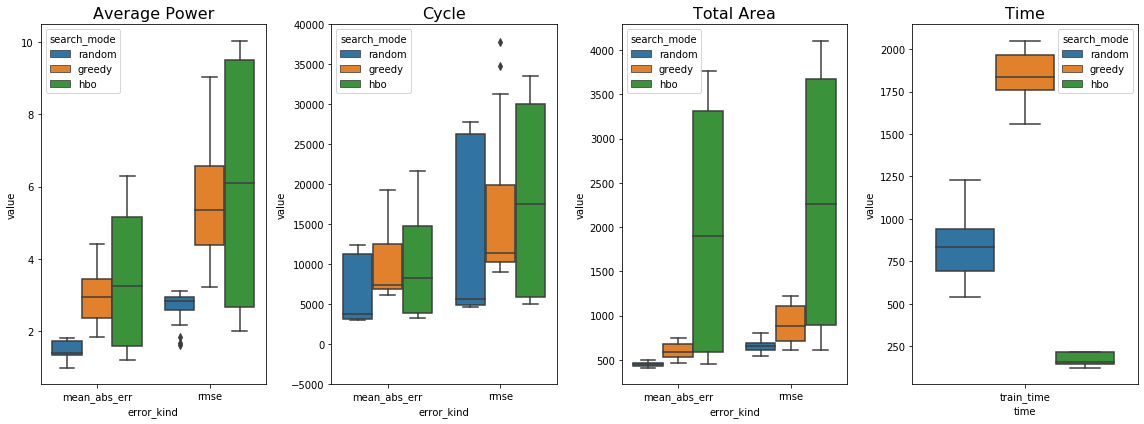

In [19]:
notch = False

plt.figure(figsize=(16, 6))

plt.subplot(141)
plt.title("Average Power", fontsize=16)
sns.boxplot(x='error_kind', y='value', hue='search_mode', data=avg_power_df, notch=notch)

plt.subplot(142)
plt.title("Cycle", fontsize=16)
sns.boxplot(x='error_kind', y='value', hue='search_mode', data=cycle_df, notch=notch, whis=1.5)
plt.ylim([-5000, 40000])

plt.subplot(143)
plt.title("Total Area", fontsize=16)
sns.boxplot(x='error_kind', y='value', hue='search_mode', data=total_area_df, notch=notch, whis=1.5, sym='')

plt.subplot(144)
plt.title("Time", fontsize=16)
sns.boxplot(x='time', y='value', hue='search_mode', data=time_df, notch=notch, whis=1.5, sym='')

plt.tight_layout()

plt.savefig(f"{save_dir}/stencil3d/random_vs_greedy.png")

plt.show()

In [205]:
hbo_df["perm"].nunique()

3

In [178]:
hbo_df

,model,index,output,size,perm,train_time,predict_time,rmse,mean_abs_err,mean_squ_err,search_mode
0,gpar,0,fu_power,100,"[6, 5, 3, 4, 1, 2, 7, 8, 0, 9, 10, 11]",735.040443,0.540957,86336.264332,85827.820715,7.453951e+09,hbo
1,gpar,0,avg_fu_dynamic_power,100,"[6, 5, 3, 4, 1, 2, 7, 8, 0, 9, 10, 11]",735.040443,0.540957,3.255914,2.433036,1.060098e+01,hbo
2,gpar,0,avg_fu_leakage_power,100,"[6, 5, 3, 4, 1, 2, 7, 8, 0, 9, 10, 11]",735.040443,0.540957,40.754879,29.106923,1.660960e+03,hbo
3,gpar,0,avg_mem_power,100,"[6, 5, 3, 4, 1, 2, 7, 8, 0, 9, 10, 11]",735.040443,0.540957,5.894997,4.556884,3.475099e+01,hbo
4,gpar,0,avg_mem_dynamic_power,100,"[6, 5, 3, 4, 1, 2, 7, 8, 0, 9, 10, 11]",735.040443,0.540957,34.355349,22.930779,1.180290e+03,hbo
...,...,...,...,...,...,...,...,...,...,...,...
259,gpar,21,mem_area,100,"[5, 1, 2, 8, 0, 3, 4, 7, 6, 9, 10, 11]",723.873817,0.499620,338.208433,176.437772,1.143849e+05,hbo
260,gpar,21,num_register,100,"[5, 1, 2, 8, 0, 3, 4, 7, 6, 9, 10, 11]",723.873817,0.499620,86243.664833,85736.654000,7.437970e+09,hbo
261,gpar,21,avg_power,100,"[5, 1, 2, 8, 0, 3, 4, 7, 6, 9, 10, 11]",723.873817,0.499620,1.751272,1.121648,3.066955e+00,hbo
262,gpar,21,cycle,100,"[5, 1, 2, 8, 0, 3, 4, 7, 6, 9, 10, 11]",723.873817,0.499620,4671.134449,3020.593165,2.181950e+07,hbo
